In [1]:
import apy

settings = apy.sim_params(
    grid=apy.dim_params(n=(100,50,10), d=1e-9),
    time=apy.dim_params(d=1e-14, n=1000),
    Ms=8e5, alpha=0.8,
    **{'A':1e-11, 'K':0.1e3, 'D':1.58e-3, 'Hmag':0.1e3},
    frames=10,
    init="flower")
apy.write_settings(settings, "temp/settings.json")

In [5]:
import os
import sys

input_file = "temp/settings.json"
output_file = "temp/data.json"

if not "DEVITO_OPENMP" in os.environ or os.environ["DEVITO_OPENMP"] != "1":
    print("*** WARNING: Devito OpenMP environment variable has not been set ***", file=sys.stderr)
os.environ['OMP_NUM_THREADS'] = "8"

import numpy as np
from sympy import Matrix, Eq, solve
from devito import Grid, Function, TimeFunction, configuration, Operator
import progressbar
import apy

def vector_laplacian(u):
    return Matrix([u[0].dx2 + u[0].dy2 + u[0].dz2,
                   u[1].dx2 + u[1].dy2 + u[1].dz2,
                   u[2].dx2 + u[2].dy2 + u[2].dz2])

def vector_gradient(u):
    return u[0].dx**2 + u[0].dy**2 + u[0].dz**2 + u[1].dx**2 + u[1].dy**2 + u[1].dz**2 + u[2].dx**2 + u[2].dy**2 + u[2].dz**2

def curl(u):
    return Matrix([u[2].dy - u[1].dz,
                   u[0].dz - u[2].dx,
                   u[1].dx - u[0].dy])

def VectorTimeFunction(name, settings):
    return Matrix([TimeFunction(name='{}_x'.format(name), **settings), TimeFunction(name='{}_y'.format(name), **settings), TimeFunction(name='{}_z'.format(name), **settings)])


def VectorDenseData(name, settings):
    return Matrix([Function(name='{}_x'.format(name), **settings), Function(name='{}_y'.format(name), **settings), Function(name='{}_z'.format(name), **settings)])

settings = apy.Struct(apy.read_settings(input_file))
buffer_params = apy.Struct(apy.buffer_params(settings, 1))

grid = Grid(shape=buffer_params.buffer_dims, extent=settings.grid.l)
data_settings = {"grid":grid, "space_order":2}
m = VectorTimeFunction('m', data_settings)

c = 2 / (settings.mu0 * settings.Ms)
zeeman = Matrix(settings.Hdir) * settings.Hmag
exchange = settings.A * c * vector_laplacian(m)
e = Matrix(settings.e)
anisotropy = settings.K * c * m.dot(e) * e
dmi = settings.D * c * curl(m)
heff = zeeman + exchange + anisotropy + dmi
crossHeff = m.cross(heff)
dmdt_rhs = -settings.gamma0 / (1 + settings.alpha**2) * (crossHeff + settings.alpha * m.cross(crossHeff))
dmdt_lhs = VectorTimeFunction('dmdt', data_settings)
dmdt_correction = settings.correction * dmdt_lhs.dot(dmdt_lhs)**0.5 * (1 - m.dot(m)) * m

update = []
if settings.correction > 0:
    # if using correction solve in 2 steps; calculate dmdt, then calculate m[t+1] = dmdt + correction
    for i, dmdti in enumerate(dmdt_lhs):
        update.append(Eq(dmdti, dmdt_rhs[i]))
    llg_eqn = Matrix([mi.dt for mi in m]) - (dmdt_lhs + dmdt_correction)
else:
    # if not using correction; m[t+1] = dmdt
    llg_eqn = Matrix([mi.dt for mi in m]) - dmdt_rhs

print("Solving LLG Sympy expressions ...", file=sys.stderr)
for i, mi in enumerate(m):
    update.append(Eq(mi.forward, solve(llg_eqn[i], mi.forward)[0]))

boundary = 1
bcs = []
nx, ny, nz = tuple(int(n + 2 * boundary) for n in settings.grid.n)
x, y, z = grid.dimensions
t = grid.stepping_dim
if settings.periodic_boundary:
    for mi in m:
        bcs += [Eq(mi.indexed[t, x, y, 0], mi.indexed[t, x, y, nz - 2])]
        bcs += [Eq(mi.indexed[t, x, y, nz - 1], mi.indexed[t, x, y, 1])]
        bcs += [Eq(mi.indexed[t, x, 0, z], mi.indexed[t, x, ny - 2, z])]
        bcs += [Eq(mi.indexed[t, x, ny - 1, z], mi.indexed[t, x, 1, z])]
        bcs += [Eq(mi.indexed[t, 0, y, z], mi.indexed[t, nx - 2, y, z])]
        bcs += [Eq(mi.indexed[t, nx - 1, y, z], mi.indexed[t, 1, y, z])]
else:
    for mi in m:
        bcs += [Eq(mi.indexed[t, x, y, 0], 0.)]
        bcs += [Eq(mi.indexed[t, x, y, nz - 1], 0.)]
        bcs += [Eq(mi.indexed[t, x, 0, z], 0.)]
        bcs += [Eq(mi.indexed[t, x, ny - 1, z], 0.)]
        bcs += [Eq(mi.indexed[t, 0, y, z], 0.)]
        bcs += [Eq(mi.indexed[t, nx - 1, y, z], 0.)]

print("Generating code ...", file=sys.stderr)
op = Operator(bcs + update, dse=None)
print("Compiling code ...", file=sys.stderr)
op.cfunction # compile

num_threads = int(os.environ['OMP_NUM_THREADS']) if 'OMP_NUM_THREADS' in os.environ else 1
data = apy.Data(settings, "Devito", num_threads)

print("Running simulation ...", file=sys.stderr)
data.start_timer()
for frame in range(settings.frames):
    data.push((frame + 1) * settings.time.d * settings.save_every)
    for i, mi in enumerate(m):
        mi.data[(0, ) + buffer_params.buffer_slice] = data[-2][i]
    op(time=settings.save_every + 1, dt=settings.time.d)
    for i, mi in enumerate(m):
        data[-1][i] = mi.data[(settings.save_every % 2, ) + buffer_params.buffer_slice]
data.end_timer()

Solving LLG Sympy expressions ...
Generating code ...
Compiling code ...
IntelCompiler: compiled /tmp/devito-_746yynn/3b7bf914e45d01f7dd038c9efd17ba6bc3208e63.c [13.77 s]
Running simulation ...
Section section_0<101,101,51> with OI=0.00 computed in 0.000 s [0.00 GFlops/s]
Section section_1<101,101,11> with OI=0.00 computed in 0.003 s [0.00 GFlops/s]
Section section_2<101,51,11> with OI=0.00 computed in 0.000 s [0.00 GFlops/s]
Section main<101,101,51,11> with OI=27.62 computed in 0.047 s [91.55 GFlops/s, 0.12 GPts/s]
Section section_0<101,101,51> with OI=0.00 computed in 0.000 s [0.00 GFlops/s]
Section section_1<101,101,11> with OI=0.00 computed in 0.007 s [0.00 GFlops/s]
Section section_2<101,51,11> with OI=0.00 computed in 0.000 s [0.00 GFlops/s]
Section main<101,101,51,11> with OI=27.62 computed in 0.131 s [32.91 GFlops/s, 0.04 GPts/s]
Section section_0<101,101,51> with OI=0.00 computed in 0.000 s [0.00 GFlops/s]
Section section_1<101,101,11> with OI=0.00 computed in 0.010 s [0.00 GF

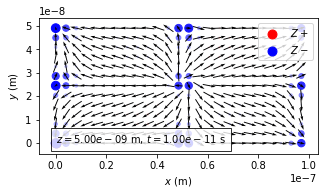

(<matplotlib.figure.Figure at 0x7f2c1b405c50>,
 4,
 [Text(0,0,'$z = 5.00e-09$ m, $t=1.00e-11$ s')],
 80.0)

In [6]:
import apy.plotting as plt
plt.frame(data[-1], settings.grid.n[2] // 2, settings.grid.l, data.times[-1], image_width=5)